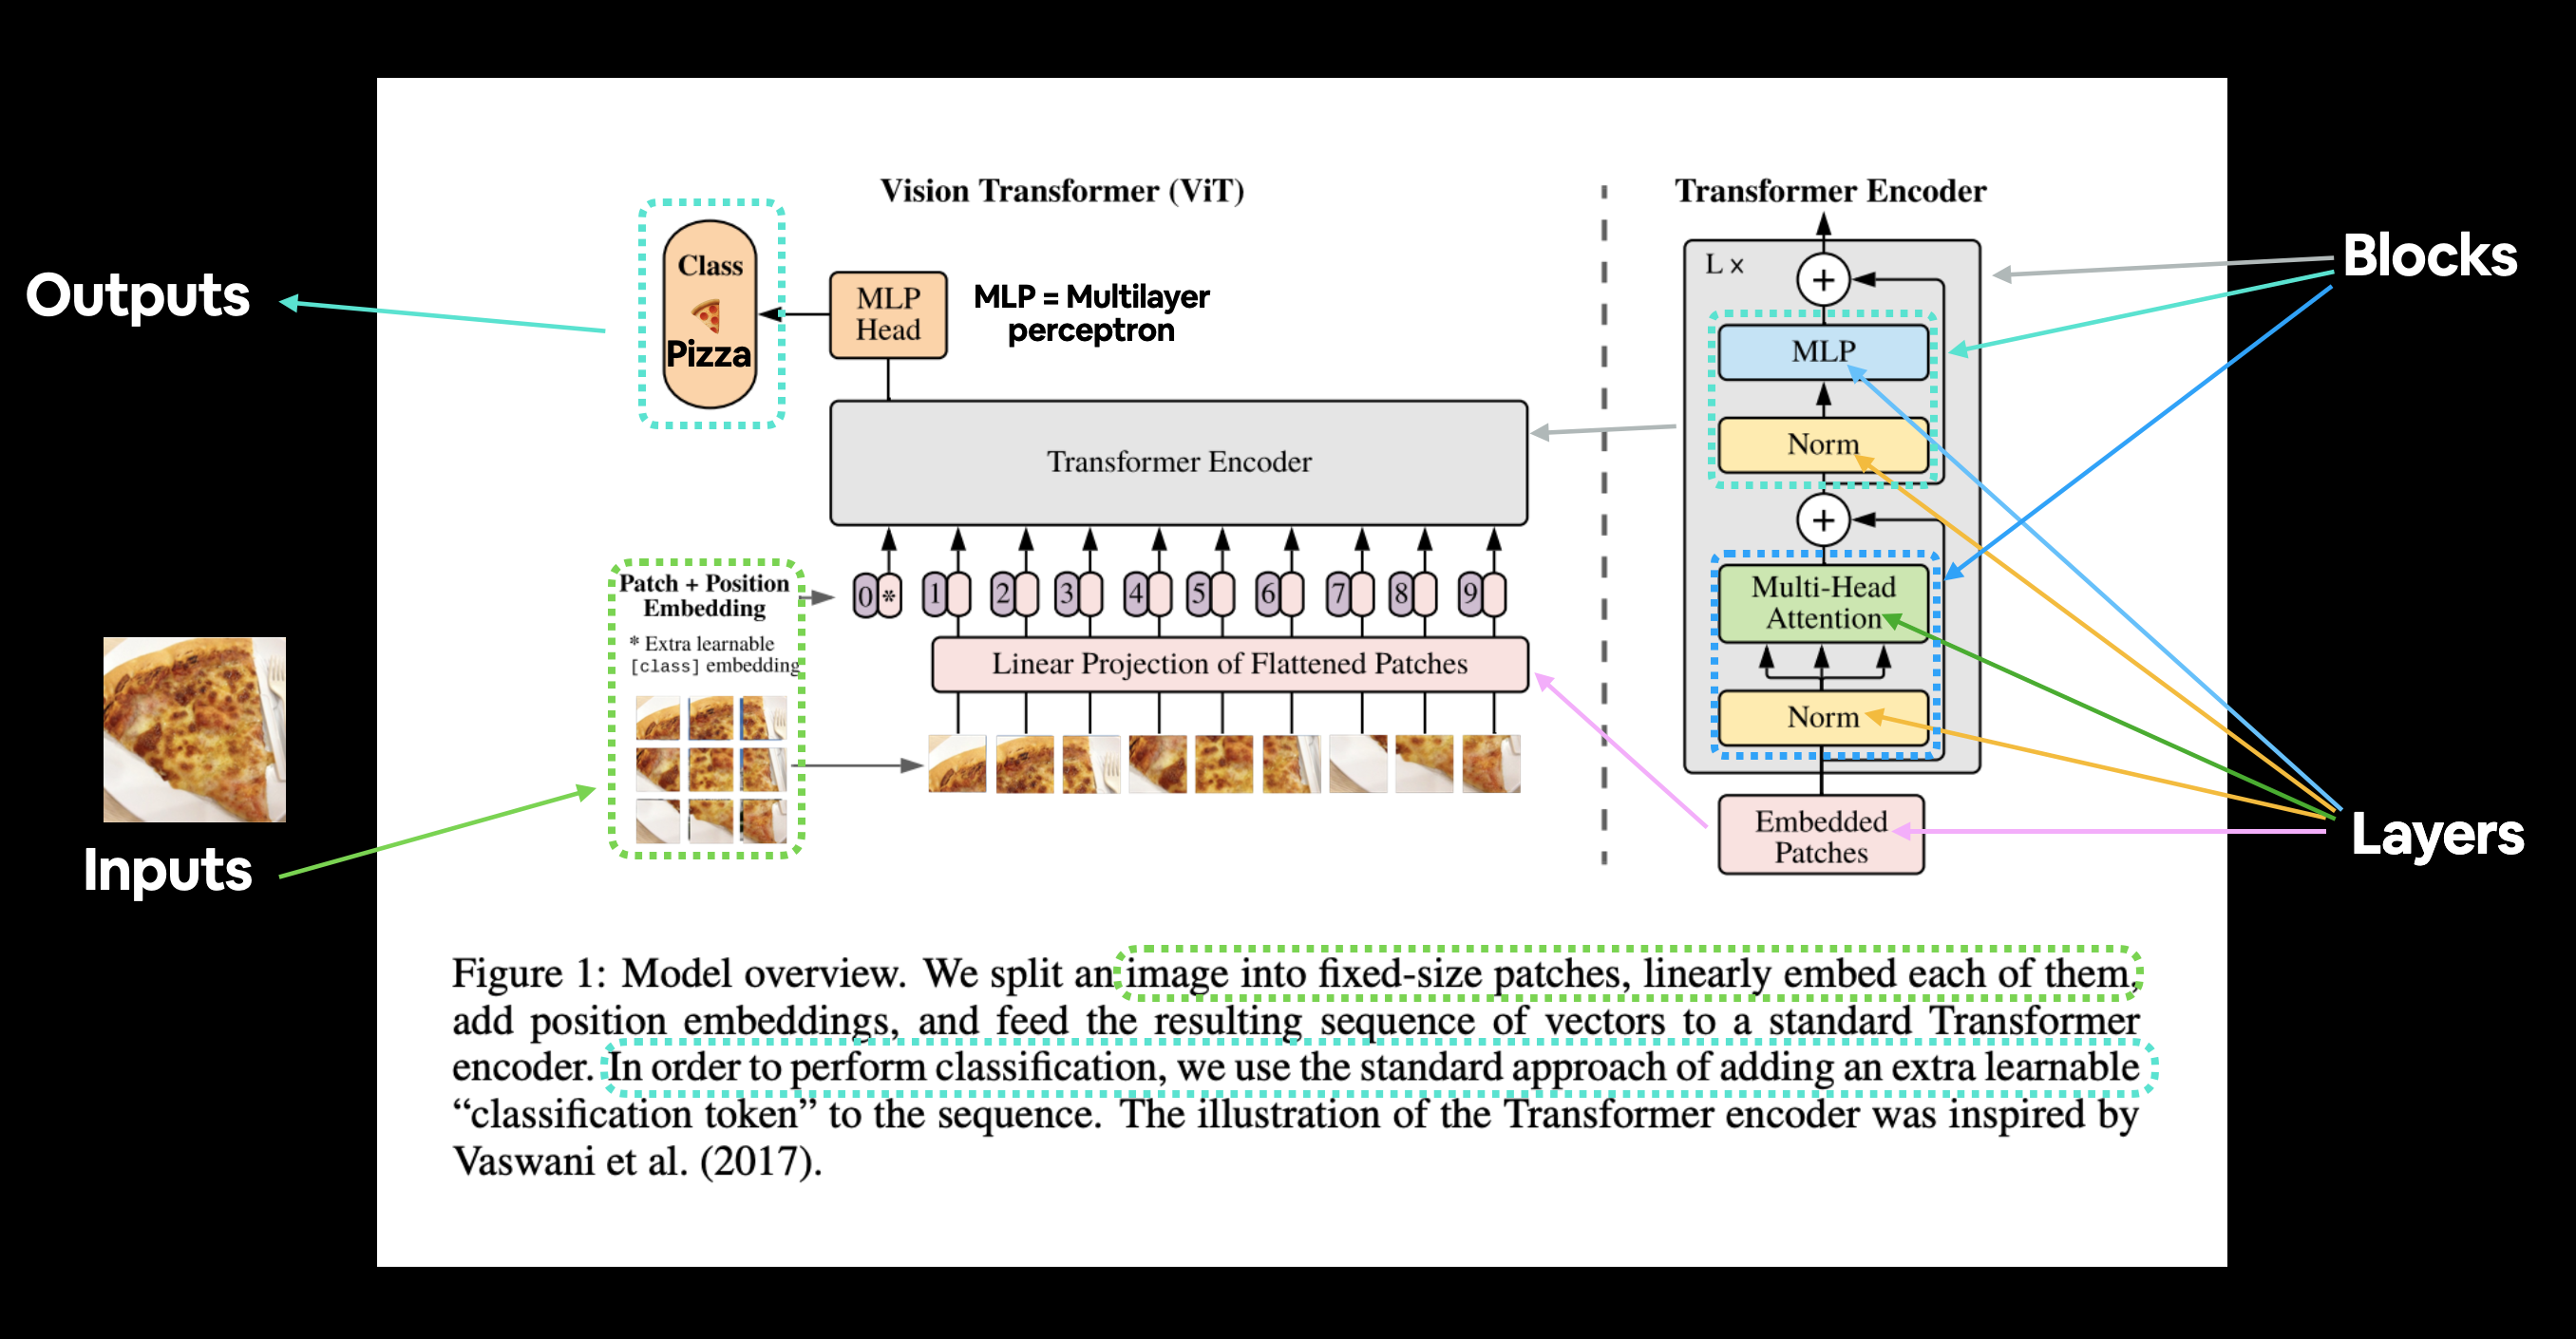

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
torch.__version__, torchvision.__version__

('1.13.1+cu116', '0.14.1+cu116')

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 3416 (delta 47), reused 92 (delta 39), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir=image_path/"train"
test_dir=image_path/"test"

In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms
IMG_SIZE=224 #Table 3 of the ViT paper
manual_transforms=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                      transforms.ToTensor()])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [ ]:
BATCH_SIZE=32

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,
                                                                           transform=manual_transforms,
                                                                           batch_size=BATCH_SIZE)

In [ ]:
len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [ ]:
image_batch,label_batch=next(iter(train_dataloader))

In [ ]:
image,label=image_batch[0],label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

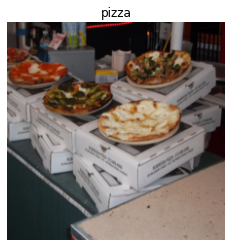

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

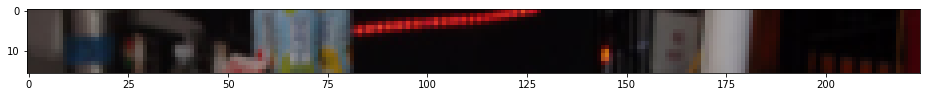

In [ ]:
image_permute=image.permute(1,2,0)

patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permute[:patch_size,:,:])

In [ ]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0,"Image size must be divisible by Patch size"

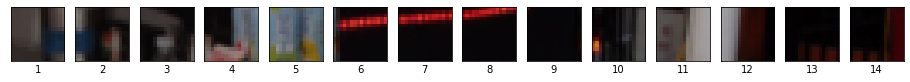

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=img_size//patch_size,sharex=True,sharey=True,figsize=(patch_size,patch_size))

for i, patch in enumerate(range(0,img_size,patch_size)):
  ax[i].imshow(image_permute[:patch_size,patch:patch+patch_size,:])
  ax[i].set_xlabel(i+1)
  ax[i].set_xticks([])
  ax[i].set_yticks([])


In [ ]:
img_size=224
patch_size=16
num_patches=img_size//patch_size
assert img_size%patch_size==0,"Image size must be divisible by patch size"


Text(0.5, 0.98, 'pizza -> Patchified')

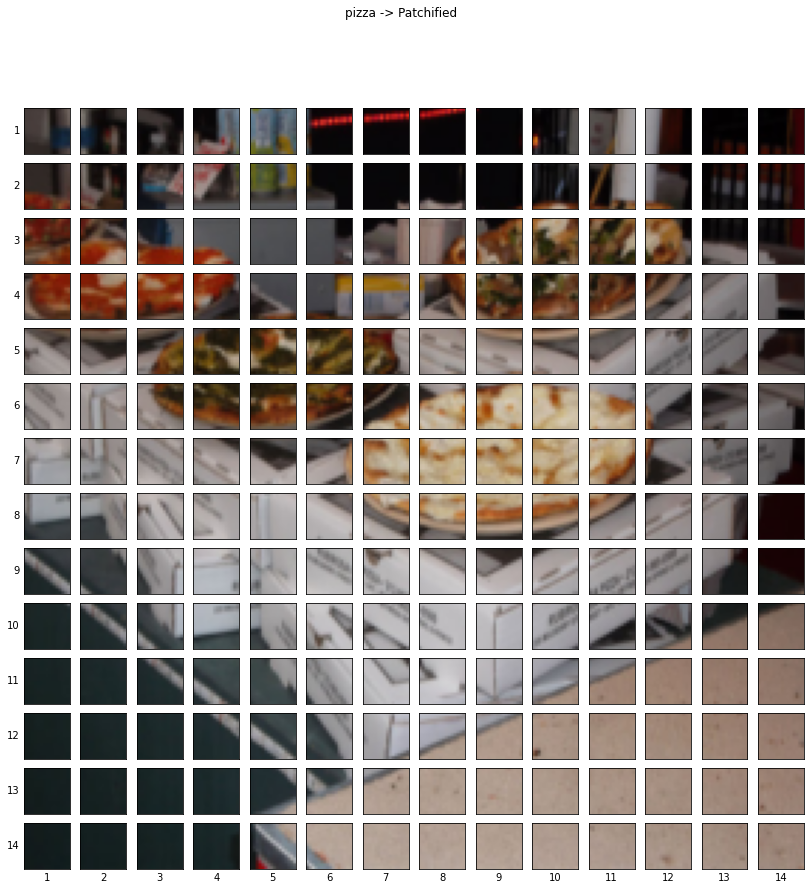

In [ ]:
fig,ax=plt.subplots(nrows=img_size//patch_size,ncols=img_size//patch_size,figsize=(num_patches,num_patches),
                    sharex=True,sharey=True)

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    ax[i,j].imshow(image_permute[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    ax[i,j].set_ylabel(i+1,rotation="horizontal",horizontalalignment="right",verticalalignment="center")
    ax[i,j].set_xlabel(j+1)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified")


In [ ]:
from torch import nn
patch_size=16
conv2d=nn.Conv2d(in_channels=3,out_channels=768,kernel_size=patch_size,stride=patch_size,padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

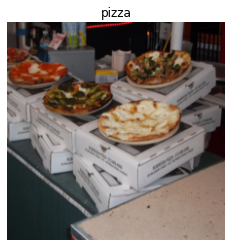

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image_out_of_conv=conv2d(image.unsqueeze(0))
image_out_of_conv.shape,image_out_of_conv.requires_grad

(torch.Size([1, 768, 14, 14]), True)

In [ ]:
import random

random_indexes=random.sample(range(0,768),k=5)
random_indexes

[706, 6, 595, 412, 676]

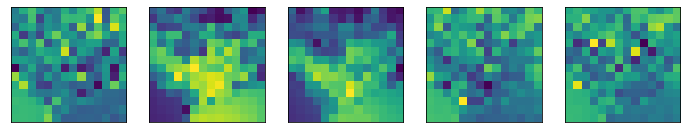

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=5,figsize=(12,12))
for i,idx in enumerate(random_indexes):
  image_conv_feature_map=image_out_of_conv[:,idx,:,:]
  ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  ax[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


In [ ]:
single_feature_map=image_out_of_conv[:,0,:,:]
image_out_of_conv.shape,image_out_of_conv.requires_grad

(torch.Size([1, 768, 14, 14]), True)

In [ ]:
from torch import nn
flatten_layer=nn.Flatten(start_dim=2,end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image: torch.Size([3, 224, 224])
Image out of conv shape torch.Size([1, 768, 14, 14])
Flattened image shape: torch.Size([1, 768, 196])


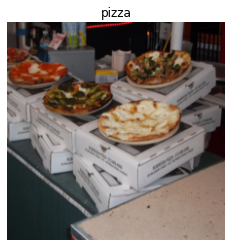

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image: {image.shape}")

image_out_of_conv=conv2d(image.unsqueeze(0))
print(f"Image out of conv shape {image_out_of_conv.shape}")
image_out_of_conv_flattened=flatten_layer(image_out_of_conv)
print(f"Flattened image shape: {image_out_of_conv_flattened.shape}")

In [ ]:
image_out_of_conv_flattened_permuted=image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

In [ ]:
single_flattened_feature_map=image_out_of_conv_flattened_permuted[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
print(f"{single_flattened_feature_map.shape}")
plt.axis(False)

torch.Size([1, 196])


(-0.5, 195.5, 0.5, -0.5)

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,in_channels:int=3,patch_size:int=16,embedding_dim:int=768):
    super().__init__()
    self.patcher=nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)
    self.flatten=nn.Flatten(start_dim=2,end_dim=3)
    self.patch_size=patch_size
  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution%patch_size==0,"Input image must be divisible by patch size"
    x_patched=self.patcher(x)
    x_flattened=self.flatten(x_patched)
    return x_flattened.permute(0,2,1)
    

In [ ]:
set_seeds()
patchify=PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)
patch_embedded_image=patchify(image.unsqueeze(0))

In [ ]:
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image_with_class_embedding=torch.cat((class_token,patch_embedded_image),dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2327,  0.0735, -0.0555,  ...,  0.0715, -0.1206,  0.1599],
          [-0.0113,  0.0188, -0.0691,  ...,  0.1575, -0.1476, -0.1041],
          ...,
          [-0.6590,  0.1393, -0.1790,  ...,  0.4335, -0.2685,  0.2433],
          [-0.5791,  0.1268, -0.1697,  ...,  0.4190, -0.2735,  0.2409],
          [-0.5822,  0.1241, -0.1630,  ...,  0.4233, -0.2739,  0.2052]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [ ]:
embedding_dimension=patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension
number_of_patches=14**2

In [ ]:
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [ ]:
patch_and_position_embedding=patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7673, 1.0735, 0.9445,  ..., 1.0715, 0.8794, 1.1599],
         [0.9887, 1.0188, 0.9309,  ..., 1.1575, 0.8524, 0.8959],
         ...,
         [0.3410, 1.1393, 0.8210,  ..., 1.4335, 0.7315, 1.2433],
         [0.4209, 1.1268, 0.8303,  ..., 1.4190, 0.7265, 1.2409],
         [0.4178, 1.1241, 0.8370,  ..., 1.4233, 0.7261, 1.2052]]],
       grad_fn=<AddBackward0>)

In [ ]:
set_seeds()
patch_size=16
print(f"Image tensor shape {image.shape}")
height,width=image.shape[1],image.shape[2]
x=image.unsqueeze(0)
print(f"Input image shape {x.shape}")
patch_embedding_layer=PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_dim=768)

patch_embedding=patch_embedding_layer(x)
print(f"Patch embedding shape {patch_embedding.shape}")

Image tensor shape torch.Size([3, 224, 224])
Input image shape torch.Size([1, 3, 224, 224])
Patch embedding shape torch.Size([1, 196, 768])


In [ ]:
batch_size=patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedding_class_token=torch.cat((class_token,patch_embedding),dim=1)
patch_embedding_class_token.shape

torch.Size([1, 197, 768])

In [ ]:
number_of_patches=196

In [ ]:
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
patch_and_position_embedding=patch_embedding_class_token+position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self,embedding_dim:int=768,num_heads:int=12,attn_dropout:int=0):
    super().__init__()
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=attn_dropout,batch_first=True)
  def forward(self,x):
    x=self.layer_norm(x)
    attn_output,_=self.multihead_attn(query=x,key=x,value=x,need_weights=False)
    return attn_output

In [ ]:
multihead_self_attention_block=MultiHeadSelfAttention(embedding_dim=768,num_heads=12,attn_dropout=0)
patched_image_through_msa_block=multihead_self_attention_block(patch_and_position_embedding)
patch_and_position_embedding.shape,patched_image_through_msa_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7673, 1.0735, 0.9445,  ..., 1.0715, 0.8794, 1.1599],
         [0.9887, 1.0188, 0.9309,  ..., 1.1575, 0.8524, 0.8959],
         ...,
         [0.3410, 1.1393, 0.8210,  ..., 1.4335, 0.7315, 1.2433],
         [0.4209, 1.1268, 0.8303,  ..., 1.4190, 0.7265, 1.2409],
         [0.4178, 1.1241, 0.8370,  ..., 1.4233, 0.7261, 1.2052]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.2020, -0.1802,  0.0884,  ..., -0.4393,  0.8671, -0.4830],
         [-0.1939, -0.1770,  0.0919,  ..., -0.4379,  0.8817, -0.4939],
         [-0.1995, -0.1764,  0.0830,  ..., -0.4357,  0.8697, -0.4927],
         ...,
         [-0.1914, -0.1706,  0.0946,  ..., -0.4378,  0.8828, -0.4984],
         [-0.1916, -0.1711,  0.0946,  ..., -0.4378,  0.8828, -0.4984],
         [-0.1918, -0.1717,  0.0944,  ..., -0.4377,  0.8828, -0.4990]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:int=0.1):
    super().__init__()
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp=nn.Sequential(
        nn.Linear(in_features=embedding_dim,out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,out_features=embedding_dim),
        nn.Dropout(p=dropout),

    )
  def forward(self,x):
    return self.mlp(self.layer_norm(x))

In [ ]:
mlp_block=MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)
patched_image_through_mlp_block=mlp_block(patched_image_through_msa_block)
patched_image_through_msa_block.shape,patched_image_through_mlp_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [ ]:
patched_image_through_mlp_block,patched_image_through_msa_block

(tensor([[[-5.4595e-02,  7.1799e-05,  1.0954e-01,  ...,  0.0000e+00,
           -1.4745e-01,  1.8792e-01],
          [-8.7711e-02, -1.1100e-01,  2.2119e-01,  ..., -8.4216e-02,
           -1.2667e-01,  2.1744e-01],
          [-1.4390e-02, -5.4514e-02,  2.3035e-01,  ..., -0.0000e+00,
           -1.8887e-01,  2.0091e-01],
          ...,
          [-2.0049e-01,  4.9171e-03,  2.2763e-01,  ...,  1.3931e-01,
           -1.9855e-01,  2.8588e-01],
          [-1.3186e-01,  5.5232e-02,  0.0000e+00,  ...,  7.1897e-02,
           -1.7736e-01,  8.5285e-02],
          [-6.1584e-02, -2.1961e-02,  1.8209e-01,  ..., -8.3478e-02,
           -1.6157e-01,  1.9001e-01]]], grad_fn=<MulBackward0>),
 tensor([[[-0.2020, -0.1802,  0.0884,  ..., -0.4393,  0.8671, -0.4830],
          [-0.1939, -0.1770,  0.0919,  ..., -0.4379,  0.8817, -0.4939],
          [-0.1995, -0.1764,  0.0830,  ..., -0.4357,  0.8697, -0.4927],
          ...,
          [-0.1914, -0.1706,  0.0946,  ..., -0.4378,  0.8828, -0.4984],
          [-0

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,num_heads:int=12,mlp_size:int=3072,mlp_dropout:int=0.1,attn_dropout:int=0):
    super().__init__()
    self.msa_block=MultiHeadSelfAttention(embedding_dim=embedding_dim,num_heads=num_heads,attn_dropout=attn_dropout)
    self.mlp_block=MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)
  def forward(self,x):
    x=self.msa_block(x) + x
    x=self.mlp_block(x) + x
    return x

In [ ]:
transformer_encoder_block=TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttention (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
torch_transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768,nhead=12,dim_feedforward=3072,dropout=0.1,
                                                      activation="gelu",batch_first=True,norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
from torchinfo import summary
summary(model=torch_transformer_encoder_layer,input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [ ]:
class ViT(nn.Module):
  def __init__(self,img_size:int=224,in_channels=3,patch_size:int=16,num_transformer_layers:int=12,
               embedding_dim:int=768,mlp_size:int=3072,num_heads:int=12,attn_dropout:int=0.1,mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,num_classes:int=1000):
    super().__init__()
    assert img_size%patch_size==0,"Image size must be divisible by patch size"
    self.num_patches=(img_size*img_size)//patch_size**2
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)
    self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)
    self.patch_embedding=PatchEmbedding(in_channels=in_channels,patch_size=patch_size,embedding_dim=embedding_dim)
    self.transformer_encoder=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,num_heads=num_heads,mlp_size=mlp_size,mlp_dropout=mlp_dropout) 
                                                                    for _ in range(num_transformer_layers)])
    self.classifier=nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                  nn.Linear(in_features=embedding_dim,out_features=num_classes))
  def forward(self,x):
    batch_size=x.shape[0]
    class_token=self.class_embedding.expand(batch_size,-1,-1)
    x=self.patch_embedding(x)
    x=torch.cat((class_token,x),dim=1)
    x=self.position_embedding + x
    x=self.embedding_dropout(x)
    x=self.transformer_encoder(x)
    x=self.classifier(x[:,0])
    return x

In [ ]:
embedding_dim=768
batch_size=32
class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)
class_embedding_expand=class_embedding.expand(batch_size,-1,-1)
class_embedding.shape,class_embedding_expand.shape


(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [ ]:
vit=ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttention(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1)

In [ ]:
set_seeds()
random_image_tensor=torch.randn(1,3,224,224)
vit=ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary
summary(model=vit,input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [ ]:
optimizer=torch.optim.Adam(vit.parameters(),lr=1e-3,betas=(0.9,0.999),weight_decay=0.3)
loss_fn=torch.nn.CrossEntropyLoss()

In [ ]:
from going_modular.going_modular import engine
set_seeds()
results=engine.train(model=vit,train_dataloader=train_dataloader,test_dataloader=test_dataloader,
                     optimizer=optimizer,loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8340 | train_acc: 0.2734 | test_loss: 1.5615 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6419 | train_acc: 0.2812 | test_loss: 2.4799 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.8981 | train_acc: 0.3008 | test_loss: 1.3586 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1957 | train_acc: 0.4102 | test_loss: 1.4496 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1900 | train_acc: 0.3008 | test_loss: 1.0754 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1440 | train_acc: 0.3008 | test_loss: 1.1566 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1163 | train_acc: 0.4062 | test_loss: 1.1488 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1388 | train_acc: 0.2930 | test_loss: 1.1323 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1802 | train_acc: 0.3008 | test_loss: 1.0703 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2050 | train_acc: 0.2852 | test_loss: 1.0851 | test_acc: 0.5417


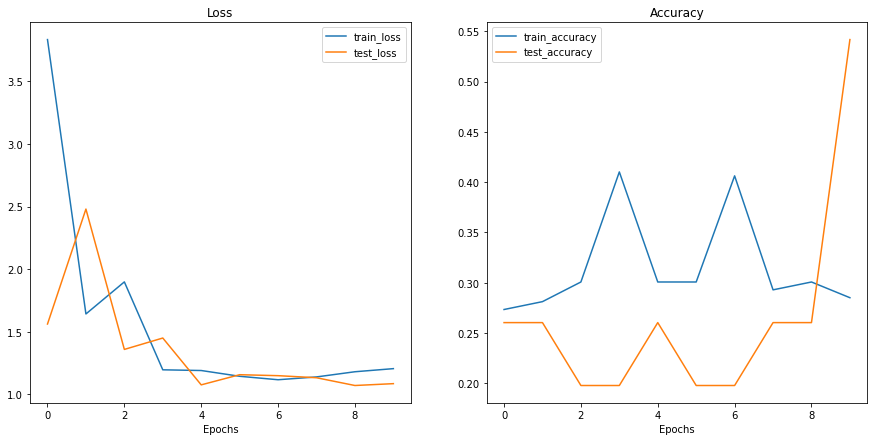

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [ ]:
pretrained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit=torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
for parameter in pretrained_vit.parameters():
  parameter.requires_grad=False
set_seeds()

In [ ]:
from torchinfo import summary
summary(model=pretrained_vit,input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [ ]:
pretrained_vit.heads=nn.Linear(in_features=768,out_features=len(class_names)).to(device)

In [ ]:
vit_transforms=pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dataloader_pretrained,test_dataloader_pretrained,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,test_dir=test_dir,transform=vit_transforms,batch_size=32)

In [ ]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss()
set_seeds()
pretrained_vit_results=engine.train(model=pretrained_vit,train_dataloader=train_dataloader_pretrained,
                                    test_dataloader=test_dataloader_pretrained,optimizer=optimizer,
                                    loss_fn=loss_fn,epochs=10,device=device
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7998 | train_acc: 0.6406 | test_loss: 0.5355 | test_acc: 0.8778
Epoch: 2 | train_loss: 0.3498 | train_acc: 0.9297 | test_loss: 0.3381 | test_acc: 0.8883
Epoch: 3 | train_loss: 0.2110 | train_acc: 0.9609 | test_loss: 0.2634 | test_acc: 0.8883
Epoch: 4 | train_loss: 0.1591 | train_acc: 0.9688 | test_loss: 0.2293 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.1280 | train_acc: 0.9727 | test_loss: 0.2190 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1382 | train_acc: 0.9766 | test_loss: 0.2120 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.0974 | train_acc: 0.9805 | test_loss: 0.2487 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0845 | train_acc: 0.9844 | test_loss: 0.2392 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1128 | train_acc: 0.9844 | test_loss: 0.2114 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0673 | train_acc: 0.9883 | test_loss: 0.1806 | test_acc: 0.9176


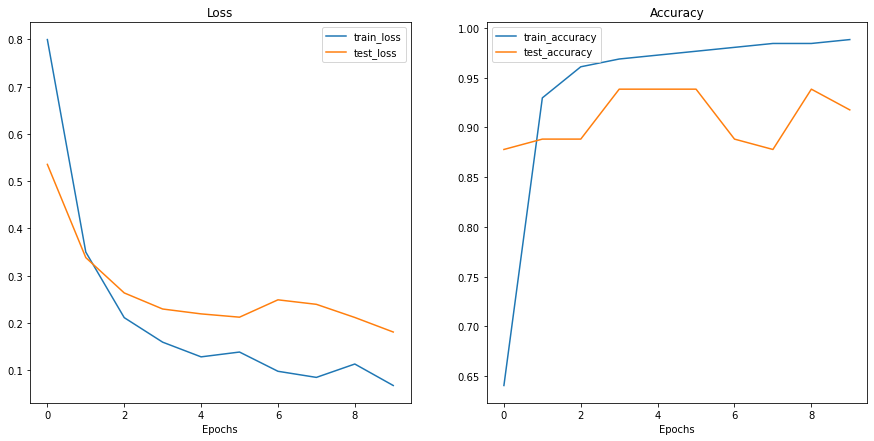

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [ ]:
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [ ]:
from pathlib import Path
pretrained_vit_model_size=Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size//(1024*1024)
print(pretrained_vit_model_size)

In [ ]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)